In [1]:
%matplotlib inline
import seaborn
import json
import pandas as pd
import numpy as np
from rtbtc import create_app
from rtbtc.extensions import influxdb
app = create_app()

In [64]:
data =  influxdb.dfquery("select sum(cost) from trades where time > now() - 1h group by time(1m);")

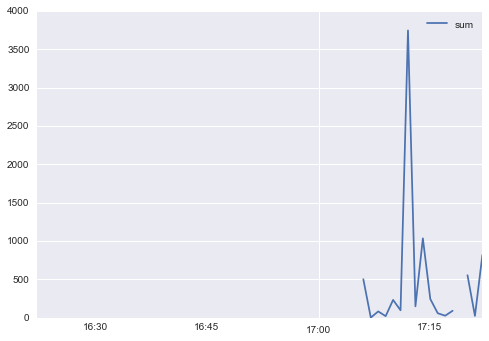

In [65]:
data['trades'].plot()

In [7]:
data

ResultSet({'('orders', None)': [{'time': '1970-01-01T00:00:00Z', 'mean': 265.913005181347}]})

In [28]:
cq = """CREATE CONTINUOUS QUERY mean_order_price_1m ON rtbtc BEGIN 
    SELECT MEAN(price) as mean_price INTO rtbtc.sampled.mean_order_price_1m FROM orders where type='open' GROUP BY time(1m), side 
END"""

In [29]:
print(cq)

CREATE CONTINUOUS QUERY mean_order_price_1m ON rtbtc BEGIN 
    SELECT MEAN(price) as mean_price INTO rtbtc.sampled.mean_order_price_1m FROM orders where type='open' GROUP BY time(1m), side 
END


In [30]:
influxdb.query(cq)

ResultSet({})

In [66]:
series = influxdb.dfquery('select * from "rtbtc"."sampled".mean_order_price_1m where side=\'buy\' and time > now() - 1h;')

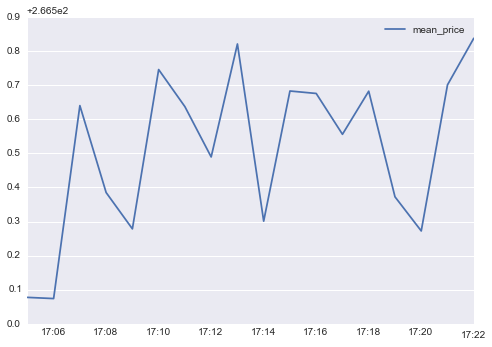

In [67]:
series[('mean_order_price_1m', (('side', 'buy'),))].plot()

In [68]:
from datetime import datetime, timedelta
from pyinfluxql import Query
from pyinfluxql.functions import Mean
mean_order_sell_price_q = Query(Mean('price').as_('mean_sell_price')).from_('orders').where(type='open', side='sell').date_range(start=datetime.utcnow() - timedelta(minutes=30)).group_by(time=timedelta(minutes=1))
mean_order_buy_price_q = Query(Mean('price').as_('mean_buy_price')).from_('orders').where(type='open', side='buy').date_range(start=datetime.utcnow() - timedelta(minutes=30)).group_by(time=timedelta(minutes=1))
mean_order_sell_price_df = influxdb.dfengine.execute(mean_order_sell_price_q)
mean_order_buy_price_df = influxdb.dfengine.execute(mean_order_buy_price_q)

In [69]:
df = mean_order_buy_price_df['orders'].join(mean_order_sell_price_df['orders'])

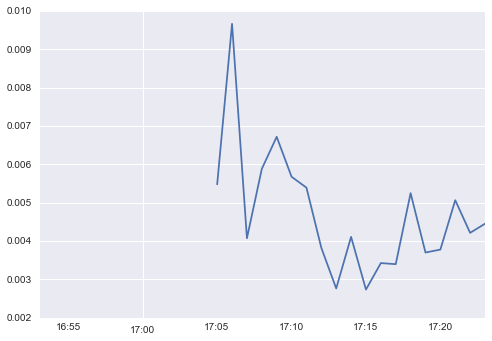

In [70]:
spread = df.apply(lambda row: np.absolute(row['mean_buy_price'] - row['mean_sell_price'] ) / row['mean_sell_price'], axis='columns')
spread.plot()